In [20]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

In [165]:
def Mmatrix(data, m_vec, dim_vec, balance):
    # data is the sufficient statistic data
    num_sam,d_num = np.shape(data)
    # number of sample is 990
    # number of d is 64
#     print(num_sam)
    
    #m_vec = [1, m1 m2 m3 m4]
    #dim_vec = [1, dim1, dim2, dim3, dim4]
    
    #m1: number of Bernoulli sample  = 8
    #dim1: T(x) dimension of Bernoulli sample = 1
    
    #m2: number of Gaussian sample = 8
    #dim2: T(x) dimension of Gaussian sample = 1
        
    #m3: number of Gamma sample = 8
    #dim3: T(x) dimension of Gamma sample = 2
    
    #m4: number of Dirichlet sample  = 8 
     #dim4: T(x) dimension of Dirichlet sample = 3
    
    
#     balance = np.sqrt([1 1 2 3])
    endpoint1 = m_vec[1] * dim_vec[1] # 8

    ber_data = data[:,0:endpoint1]/balance[1] # index 0 to 7 are Bernoulli
    
    endpoint2 = endpoint1 + m_vec[2] * dim_vec[2] # 8 + 16 = 24

    # for gaussian case, we only need x part in [x x^2]
    gauss_data = data[:,endpoint1:endpoint2]/balance[2]
#     gauss_data = np.zeros(np.shape(ber_data))
#     k=0;
#     for i in range(endpoint1, endpoint2, 2): # i in range(8,24,2)
#         gauss_data[:,k] = data[:,i]/balance[2]
#         k=k+1
    
    endpoint3 = endpoint2 + m_vec[3] * dim_vec[3] # 24 + 8*2 = 40

    gamma_data = data[:,endpoint2:endpoint3]/balance[3] # index 24 to 40 are Gamma
    endpoint4 = endpoint3 + 2*m_vec[4] * dim_vec[4] # 40 + 8*3 = 64
    
    # the rest of them are dirichlet distribution
    dirich_data = data[:,endpoint3:endpoint4]/balance[4]
    
    vec = np.ones([num_sam,1])

    # construct new data

    new_data = np.concatenate((vec, ber_data, gauss_data, gamma_data, dirich_data), axis=1)
    
    M = np.transpose(np.matrix(new_data))*np.matrix(new_data)/num_sam
    
    return M

In [83]:
def Dmatrix(m_vec, dim_vec):
    #m_vec = [1, m1, m2, m3, m4]
    #dim_vec = [1, dim1, dim2, dim3, dim4]
    
    #m1: number of Bernoulli sample  = 8
    #dim1: T(x) dimension of Bernoulli sample = 1
    
    #m2: number of Gaussian sample = 8
    #dim2: T(x) dimension of Gaussian sample = 1
        
    #m3: number of Gamma sample = 8
    #dim3: T(x) dimension of Gamma sample = 2
    
    #m4: number of Dirichlet sample  = 8 
     #dim4: T(x) dimension of Dirichlet sample = 3
    
    # only Bernoulli has value. The rest are continuous random variable
    l0 = 0
    l1 = np.ones(dim_vec[1]*m_vec[1])
    l2 = np.zeros(dim_vec[2]*m_vec[2])
    l3 = np.zeros(dim_vec[3]*m_vec[3])
    l4 = np.zeros(dim_vec[4]*m_vec[4])
    
    #l1 = np.diag(temp);
    temp = np.hstack((l0,l1,l2,l3,l4)) # makes an array in the form of [ l0 l1 l2 l3 l4 ] 
    D = np.diag(temp)
    return D


M correspond to a matrix in the form:

       [ M11  |   M12 ] 
       --------------------         
       [ M21  |   M22 ]


In [84]:
def Block_Extract(Z, row_ind, col_ind, m, dim):
    #m = np.array([1, 8, 8, 8, 8]) # 1 for dummy variable
    #dim = np.array([1, 1, 1, 2, 3]) # 1 for dummy variable, 

    #m[0]: dummy variable, nu =1
    #dim[0]: dummy variable, nu =1
    
    #m[1]: number of Bernoulli sample  = 8
    #dim[1]: T(x) dimension of Bernoulli sample = 1
    
    #m[2]: number of Gaussian sample = 8
    #dim[2]: T(x) dimension of Gaussian sample = 1
        
    #m[3]: number of Gamma sample = 8
    #dim[3]: T(x) dimension of Gamma sample = 2
    
    #m[4]: number of Dirichlet sample  = 8 
    #dim[4]: T(x) dimension of Dirichlet sample = 3
    
    # Obtain New row index
    new_row = 0
    for i in range(len(m)): # iterate through 0 1 2 3 4
        if row_ind < m[i]:
            new_row += dim[i]*row_ind
            Rdim = dim[i]
            break
        row_ind -= m[i]
        new_row += dim[i]*m[i]
    
    # Obtain New column index
    new_col = 0
    for i in range(len(m)):
        if col_ind < m[i]:
            new_col += dim[i]*col_ind
            Cdim = dim[i]
            break
        col_ind -= m[i]
        new_col += dim[i]*m[i]

    return Z[new_row:new_row+Rdim, new_col:new_col+Cdim]
    


In [85]:
def Zupdate(theta, U, Eta, m_vec, dim_vec):
    # i = 1, ... , 32
    # j = 1, ... , 32
    # Extract number of rows and columns for Z; should be (d+1) and (d+1) respectively
    # for testing, it is a 57 by 57 matrix
    
    #m1: number of Bernoulli sample  = 8
    #dim1: T(x) dimension of Bernoulli sample = 1
    
    #m2: number of Gaussian sample = 8
    #dim2: T(x) dimension of Gaussian sample = 1
        
    #m3: number of Gamma sample = 8
    #dim3: T(x) dimension of Gamma sample = 2
    
    #m4: number of Dirichlet sample  = 8 
     #dim4: T(x) dimension of Dirichlet sample = 3
    
    row,col = theta.shape
    
    dist_num = np.sum(m_vec)-1# 32
    
    m = m_vec
    dim = dim_vec
    
    temp_matrix = theta+U
    
    B = [ [] for i in range(dist_num+1)] # [  [], [], [], ... [] ]
   
    for i in range(dist_num+1): # iterate from 0 to 32
        for j in range(dist_num+1):
            if i==0 or j==0 or i==j :
                B[i].append(Block_Extract(temp_matrix, i, j, m, dim)) # Helper function called "Block_Extract"
            else:
                gamma = la.norm(Block_Extract(temp_matrix, i, j, m, dim), 'fro')
                if gamma > Eta[i][j]:
                    B[i].append((1 - Eta[i][j]/gamma)*Block_Extract(temp_matrix, i,j, m, dim))
                else:
                    B[i].append(np.zeros(Block_Extract(temp_matrix, i, j, m, dim).shape))
                    
    # now B is [ [B0,0 , B0,1 , ... , B0,31], [B1,0 , B1,1 , ... , B1,31], ..., [B31,0, ..., B31,31]]
    Z_new = np.bmat(B)
    Z_new = (Z_new + np.transpose(Z_new))/2
    
    return Z_new


In [86]:
def ADMM(theta, Z, U, A, K, lamb, W, num_sam, m_vec, dim_vec, epsilon_abs, epsilon_rel):
    # k stands for number of iterations
    # lamb stands for the lambda, which is lasso parameter 
    # Dimension of theta, U, Z and A is (d+1) x (d+1)
    # for testing, it is 57 by 57 matrix
    
    #m_vec = np.array([1, 8, 8, 8, 8]) # 1 for dummy variable
    #dim_vec = np.array([1, 1, 1, 2, 3]) # 1 for dummy variable, 
    
    new_theta = theta
    prev_Z = Z
    
    new_U = U
    n = num_sam # 990
    
    mat_dim = theta.shape[0] # 57
    
    ###################################TEST for RHO for better result #####################################
    rho = float(3.5) # define rho
    eta1 = rho/n # define eta for theta update
    eta2 = (lamb*W)/rho; # define eta2 for Z update
    ###############################################################################################
    
    ####################################TEST for STOPPING CRITERIA#####################################
    epsilon_abs = epsilon_abs ###TO DO
    
    epsilon_rel = epsilon_rel
    ###############################################################################################
    
    # Initialize R_k and S_k
    R_k = []
    S_k = []
    epsilon_pri = []
    epsilon_dual = []
    
    new_Z = Z;
    new_U = U;
    
    for k in range(K):
        temp = np.multiply((new_Z-new_U),eta1) - A;

        temp = (temp + np.transpose(temp))/2
        np.matrix(temp)
        
        lambvec,Q = la.eig(temp)
       
        #lambmat is eigenvalue
        #v is eigenvector 
        
        Q = np.matrix(Q)
        
        # Update theta
        new_theta = (1/(2*eta1))*Q*np.diag(lambvec + np.sqrt( np.power(lambvec,2) + 4*eta1 * np.ones(len(lambvec)) )  )*np.transpose(Q)
        
        theta = new_theta # re-assign the theta (correpsond to "theta_k")
        
        # Update Z
        new_Z = Zupdate(new_theta, new_U, eta2, m_vec, dim_vec)
        
        #Calculate residual (stopping criteria 1)
            # calculate r^k
        R_k.append(la.norm(theta - new_Z, 'fro'))
        
            # calculate primal epsilon
        epsilon_pri.append( mat_dim * epsilon_abs  + epsilon_rel * max( la.norm(theta, 'fro'), la.norm(new_Z, 'fro') ) )
        
        if R_k[k] <= epsilon_pri[k]:
            sentence = 'Primal Residual True'
        
        # Calculate dual (stopping criteria 2)
            # calculate r^k
        S_k.append(rho * la.norm(new_Z-prev_Z, 'fro'))
        
        prev_Z = new_Z # Book-keeping previous Z (correspond to "Z_k")
        
        #Update U
        new_U = new_U + new_theta - new_Z
        
        # calculate dual epsilon
        epsilon_dual.append( mat_dim * epsilon_abs + epsilon_rel * rho * la.norm(new_U, 'fro'))
        

        if (k % 25) == 0:
            print '.', # python 2.7
#             print('.', end="") # python 3.5
            
#         if k > 300:
#             print('new theta is')
#             print(new_theta)
#             np.savetxt('new_theta.csv', new_theta, delimiter=',')
#             print()
#             print('new Z is')
#             print(new_Z)
        
        if S_k[k] <= epsilon_dual[k]:
            sentence = 'Dual Residual True'
        
        if R_k[k] <= epsilon_pri[k] and S_k[k] <= epsilon_dual[k]:
            sentence = 'primal and dual both met'
            break;
    
    
    ## END of Iteration ##### 
    sentence2 = 'iteration is over'
    print('Iter number :',k)
    print()
    if k == K-1:
        print('Status: Inaccurate Solution')
        print()
        print('Primal Residual is          ', R_k[k-1])    
        print()
        print('Primal Stopping criteria is ', epsilon_pri[k-1])
        print()
        print('Dual Residual is            ', S_k[k-1])
        print()
        print('Dual Stopping criteria is   ', epsilon_dual[k-1])
    else:
        print('Status: Optimial Solution')
        print('primal: ', R_k[k], 'vs', epsilon_pri[k])
        print('dual: ', S_k[k], 'vs', epsilon_dual[k])
    
    return new_theta, new_Z, new_U, R_k, S_k, epsilon_pri, epsilon_dual


In [87]:
def computeErrors(edge_matrix_actual,edge_matrix_est, Theta, A, e1,e2,e3,e4,e5,e6):
    n = edge_matrix_actual.shape[0]
    D = np.where(edge_matrix_est != 0)[0].shape[0]#len(numpy.where(S_est == 0)[0])
    T = np.where(edge_matrix_actual != 0)[0].shape[0]
#            print np.where(S_actual != 0)[0]
    TP = float(np.where(np.logical_and(edge_matrix_actual,edge_matrix_est) == True)[0].shape[0])
    
#    T = np.count_nonzero(edge_matrix_actual)
#    D = np.count_nonzero(edge_matrix_est)
#    TandD = float(np.count_nonzero( (edge_matrix_actual != 0) & (edge_matrix_est != 0) ) )
    P = TP/D
    R = TP/T
    score = 2* P*R/(P+R)
    offDiagDiff = edge_matrix_actual - edge_matrix_est
    offDiagDiff = offDiagDiff - np.diag(np.diag(offDiagDiff))
#    S_diff = (S_est - S_previous)  
#    S_diff = S_diff - np.diag(np.diag(S_diff))
#    ind = (S_diff < 1e-2) & (S_diff > - 1e-2)
#    S_diff[ind] = 0    
#    K = np.count_nonzero(S_diff)
    K = D
    AIC = -np.log(la.det(Theta)) + np.trace(np.dot(Theta, A)) + K
    TPR = TP/T
    FPR = (D-TP)/(np.square(n)-T)
    e1.append(P)
    e2.append(R)        
    e3.append(score)
#    K = float(np.where(np.logical_and((S_est>0) != (S_previous>0), S_est>0) == True)[0].shape[0])
    e4.append(AIC) #AIC
    e5.append(TPR) #AIC
    e6.append(FPR) #AIC
    
#    e4.append(alg.norm(S_est -  S_previous, 'fro'))
#     print ('\nD = ',D)
#     print('T = ', T)
#     print('T and D = ', TP)
#     print('K = ', K)
#     print('P = ', P)
#     print('R = ', R)
#     print('Score = ', score)
#     print('AIC = ', AIC)
    print ('D = ',D,'T = ', T,'TandD = ', TP, 'TPR = ', TPR, 'FPR = ', FPR, 'K = ', K,'P = ', P,'R = ', R,'Score = ', score, 'AIC = ', AIC)
    
            
    return e1, e2, e3, e4 ,e5 , e6  

In [88]:
# In[]
def genEdgeMatrix(filename_edge, n):
    edge_data = np.genfromtxt(filename_edge, delimiter=',')
    edge_data = edge_data[::2,:]
    
    numberOfEdge, dummy = edge_data.shape

    edge_matrix=np.diag(np.concatenate([np.ones(n)]))
#    edge_matrix=np.zeros([n,n])
    for k in range(numberOfEdge):
        i = edge_data[k][0]
        j = edge_data[k][1]
        edge_matrix[j,i]=1
        edge_matrix[i,j]=1
    
    return edge_matrix
# In[805]

In [89]:
def createEmatrix(theta, m_vec, dim_vec, tolerance):
    #m_vec = np.array([1, 8, 8, 8, 8]) # 1 for dummy variable
    #dim_vec = np.array([1, 1, 1, 2, 3]) # 1 for dummy variable, 
    
    m = m_vec
    dim = dim_vec
    
    dist_num = np.sum(m)-1
    E = np.zeros([dist_num+1,dist_num+1])
#     dist_num = 32;
    B = [ [] for i in range(dist_num+1)] # [  [], [], [], ... [] ]
    
    
    temp_vec = []
    for i in range(dist_num+1): # iterate from 0 to 32
        for j in range(dist_num+1):
            B[i].append(Block_Extract(theta, i, j, m, dim)) # Helper function called "Block_Extract"
            temp = la.norm(Block_Extract(theta, i, j, m, dim), 'fro')
            temp_vec.append(temp)
            if np.absolute(temp) >= tolerance: ###### tolerance!!! #### TEST FOR CHANGE ####
                E[i,j] = 1
            else:
                E[i,j] = 0

    return E[1:,1:]
            

('+++++++++++++++++++++++++++', 'Test For ', 'test3_sufficient_statistics.csv', '+++++++++++++++++++++++++++')
(990, 8) (990, 8) (990, 16) (990, 24)
('epsilon_abs is ', 0.001, 'epslion_rel is ', 0.001, 'tolerance is', 0.01)
('lambda is', 0.01)
. . . . . . . . . . . . . . . . . . . . ('Iter number :', 490)
()
Status: Optimial Solution
('primal: ', 2.4328724979906876e-05, 'vs', 0.48724604287429496)
('dual: ', 0.057167979490595516, 'vs', 0.057549181208709839)
('D = ', 914, 'T = ', 84, 'TandD = ', 78.0, 'TPR = ', 0.9285714285714286, 'FPR = ', 0.8893617021276595, 'K = ', 914, 'P = ', 0.08533916849015317, 'R = ', 0.9285714285714286, 'Score = ', 0.156312625250501, 'AIC = ', 842.02843748120983)


/Library/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


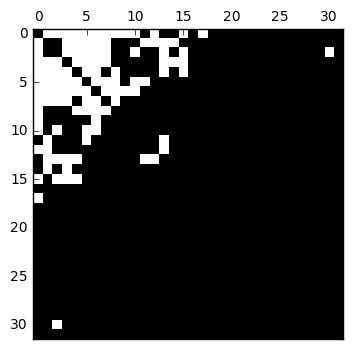

---------------------- Iteration is over --------------------------
('lambda is', 0.056234132519034911)
. . . . . . . . . . . . . . . . . . ('Iter number :', 439)
()
Status: Optimial Solution
('primal: ', 0.00015173816644647946, 'vs', 0.48161333940936624)
('dual: ', 0.060063560963853027, 'vs', 0.060087740675401818)
('D = ', 914, 'T = ', 84, 'TandD = ', 78.0, 'TPR = ', 0.9285714285714286, 'FPR = ', 0.8893617021276595, 'K = ', 914, 'P = ', 0.08533916849015317, 'R = ', 0.9285714285714286, 'Score = ', 0.156312625250501, 'AIC = ', 842.03745127924003)


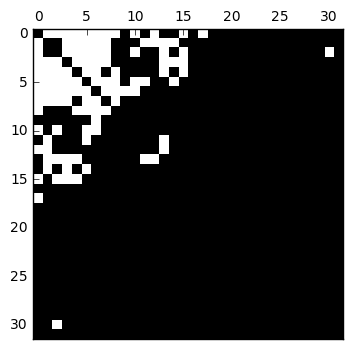

---------------------- Iteration is over --------------------------
('lambda is', 0.31622776601683794)
. . . . . . . . . . . . . . ('Iter number :', 345)
()
Status: Optimial Solution
('primal: ', 0.00096294864815335513, 'vs', 0.46527440126739833)
('dual: ', 0.073669504465448357, 'vs', 0.074351014057379164)
('D = ', 900, 'T = ', 84, 'TandD = ', 78.0, 'TPR = ', 0.9285714285714286, 'FPR = ', 0.874468085106383, 'K = ', 900, 'P = ', 0.08666666666666667, 'R = ', 0.9285714285714286, 'Score = ', 0.15853658536585366, 'AIC = ', 828.13930764552629)


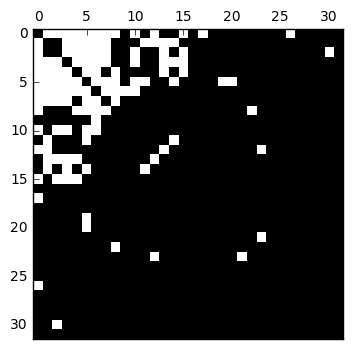

---------------------- Iteration is over --------------------------
('lambda is', 1.7782794100389228)
. . . . . . . . . . ('Iter number :', 235)
()
Status: Optimial Solution
('primal: ', 0.0098169458875451161, 'vs', 0.41939755117379252)
('dual: ', 0.1501942601057813, 'vs', 0.15251870181240823)
('D = ', 772, 'T = ', 84, 'TandD = ', 78.0, 'TPR = ', 0.9285714285714286, 'FPR = ', 0.7382978723404255, 'K = ', 772, 'P = ', 0.10103626943005181, 'R = ', 0.9285714285714286, 'Score = ', 0.18224299065420563, 'AIC = ', 700.93909117962767)


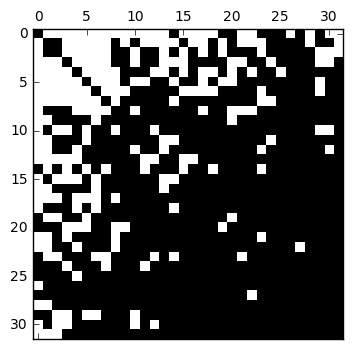

---------------------- Iteration is over --------------------------
('lambda is', 10.0)
. . . . . ('Iter number :', 105)
()
Status: Optimial Solution
('primal: ', 0.21410978474054479, 'vs', 0.34119458095922311)
('dual: ', 0.52593151785327819, 'vs', 0.53969961863988281)
('D = ', 610, 'T = ', 84, 'TandD = ', 70.0, 'TPR = ', 0.8333333333333334, 'FPR = ', 0.574468085106383, 'K = ', 610, 'P = ', 0.11475409836065574, 'R = ', 0.8333333333333334, 'Score = ', 0.2017291066282421, 'AIC = ', 544.14455099079885)


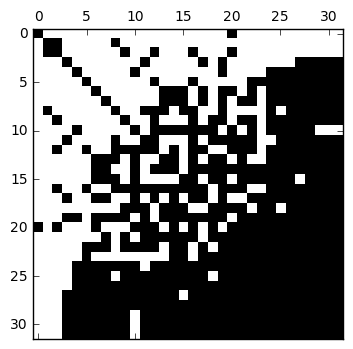

---------------------- Iteration is over --------------------------
()
('TPRvec is', [[0.9285714285714286], [0.9285714285714286], [0.9285714285714286], [0.9285714285714286], [0.8333333333333334]])
()
('FPRvec is', [[0.8893617021276595], [0.8893617021276595], [0.874468085106383], [0.7382978723404255], [0.574468085106383]])
()
[[ 0.929]
 [ 0.929]
 [ 0.929]
 [ 0.929]
 [ 0.833]]
[[ 0.889]
 [ 0.889]
 [ 0.874]
 [ 0.738]
 [ 0.574]]


In [174]:
np.set_printoptions(suppress=True, precision = 3)

###################################TEST CODE######################################
sumTPR = np.zeros([5,1]) ## intialize for summing True Positive error vector
sumFPR = np.zeros([5,1]) ## intialize for summing False Positive error vector
    
max_iter=1
for i in range(0, max_iter):
#     i = 25
#     file_name = 'sufficient_statistics_'+str(i)+'.csv'
#     file_name2 = 'modifiedEdge_'+str(i)+'.csv'
    file_name = 'test3_sufficient_statistics.csv'
    file_name2 = 'test3_edges.csv'
    print('+++++++++++++++++++++++++++', 'Test For ', file_name, '+++++++++++++++++++++++++++')

#     print('TEST for :')
#     print(file_name)
#     print(file_name2)
#     print()
    
    #########################################################################################################
    # number of Bernoulli sample, Bernoulli T(x) dimension
    # number of Gamma sample, Gamma T(x) dimension
    # number of Gaussian sample, Gaussian T(x) dimension
    # number of Dirichlet sample, Dirichlet T(x) dimension
    # respectively
       
    # n_r[0], m_t[0], n_t[1], m_r[1], n_r[2], m_t[2], n_r[3], m_t[3]
    data = np.genfromtxt(file_name, delimiter=",")
    data = data[:1000]
    m1 = 8
    m2 = 8
    m3 = 8
    m4 = 8
    
    dim1 = 1
    dim2 = 1
    dim3 = 2
    dim4 = 3
    
    m = np.array([1, m1, m2, m3, m4])
    dim = np.array([1, dim1, dim2, dim3, dim4])
    #########################################################################################################
    
    numOfType = len(dim)-1
    
    # Check if m_r and n_t are well defined according to the paper notations.
    if len(m) == len(dim):
        d = np.sum(np.multiply(m, dim))-1 # the dimension of augmented edge paramter matrix
#         print(d)
    else:
        print('m_r and n_t should have the same length')
    
    dist_num = np.sum(m)-1
    
#     balance = np.sqrt(dim)
    balance = [1, 1, 1, 2, 3]
#     balance = [1, 1, 1, 3, 2 ]
    
    M = Mmatrix(data, m, dim, balance)
    
    D = Dmatrix(m, dim) 
    A = M+D
    A = np.matrix(A) #+ np.identity(57)
    A = (A + np.transpose(A))/2
    
    # Generate A for a test
    #A = np.random.randn(57,57)
    
    #     Lamvec, Vec = la.eig(A)
    #     min_lamb = min(Lamvec)
    #     #A = A + np.identity(d+1)*(-1*(min_lamb) + 0.01)    
    #     #Lamvec,Vec = la.eig(A)
    #     min_lamb = min(Lamvec)
    #     if min_lamb> 0:
    #         print('PSD! with min_lamb',min_lamb)
    #     else:
    #         print('Negatve Definite with min_lamb', min_lamb)

    #np.savetxt('A.csv', A, delimiter=',')

    ### initialize Theta ###
    theta = np.ones([d+1, d+1])*0.1  # theta is a 57 x 57 matrix with each entries with 0.1

    Z = np.ones([d+1,d+1])*0.2 #57x57 identity matrix ------- when I made this matrix to 0 matrix, in theta update, it calculates (Z - U) as (0 mat - 0 mat) gives error
    U = np.zeros([d+1, d+1])*0.1 #0 matirx
    K = 1000 # maximum number of ADMM iteration
    
    Mvec = np.zeros([dist_num+1,1])
    for j in range(dist_num+1):
        if j< 9:
            Mvec[j] = 1
        elif j < 17:
            Mvec[j] = 1
        elif j < 25:
            Mvec[j] = 2
        else:
            Mvec[j] = 3
    
    ####################################### TEST for different W matrix ###################################
    Wmatrix = np.sqrt(Mvec * np.transpose(Mvec))
#     Wmatrix = np.power(Mvec * np.transpose(Mvec),2)
#     Wmatrix = np.ones([dist_num+1,dist_num+1])
    W = Wmatrix 
    #np.savetxt('Wmatrix.csv', W, delimiter=',')
    ################################################################################################
    
    number_of_sample,d_num = np.shape(data)
    
    ################################TEST for different LAMBDA value ###########################################
    set_length = 5
    lamb = np.logspace(-2, 1, set_length) #where set_length is the number of points in the ROC graph
#     lamb = [10]
    ################################################################################################
    
    ################################################################################################
    epsilon_abs = 1e-3
    epslion_rel =  1e-3
    tol = 1e-2
    print('epsilon_abs is ', epsilon_abs, 'epslion_rel is ', epslion_rel, 'tolerance is', tol)
    ################################################################################################
    
    TPRvec = []
    FPRvec = []
   
    for p in range(len(lamb)):
        
        print('lambda is',lamb[p])
#         print()
        optimal_theta, optimal_Z, optimal_U, R_k, S_k, epsilon_pri, epsilon_dual = ADMM(theta, Z, U, A, K, lamb[p], W, number_of_sample, m, dim, epsilon_abs, epslion_rel)
        
        Ematrix = createEmatrix(optimal_theta, m, dim, tol)
      
        trueEmatrix = genEdgeMatrix(file_name2, 32)
    
        e1 = []
        e2 = []
        e3 = []
        e4 = []
        e5 = []
        e6 = []

        error1, error2, error3, error4, error5, error6 = computeErrors(trueEmatrix, Ematrix, optimal_theta, A, e1,e2,e3,e4,e5,e6)
        pl.spy(Ematrix)
        pl.show()
        print('---------------------- Iteration is over --------------------------')
        TPRvec.append(error5)
        FPRvec.append(error6) 
    
    print()
    print('TPRvec is', TPRvec)
    print()
    print('FPRvec is', FPRvec)
    print()
    
    sumTPR = sumTPR + np.matrix(TPRvec)
    sumFPR = sumFPR + np.matrix(FPRvec)
    

print(sumTPR)
print(sumFPR)
sumTPR  = sumTPR/max_iter
sumFPR = sumFPR/max_iter

np.savetxt('TPR2.csv', sumTPR, delimiter=',')
np.savetxt('FPR2.csv', sumFPR, delimiter=',')


In [58]:
for tol in np.logspace(-2,-4,5):
    Ematrix = createEmatrix(optimal_theta, m, dim, tol)
    error1, error2, error3, error4, error5, error6 = computeErrors(trueEmatrix, Ematrix, optimal_theta, A, e1,e2,e3,e4,e5,e6)
        

('D = ', 544, 'T = ', 246, 'TandD = ', 138.0, 'TPR = ', 0.5609756097560976, 'FPR = ', 0.5218508997429306, 'K = ', 544, 'P = ', 0.2536764705882353, 'R = ', 0.5609756097560976, 'Score = ', 0.3493670886075949, 'AIC = ', 549.94189763273039)
('D = ', 802, 'T = ', 246, 'TandD = ', 204.0, 'TPR = ', 0.8292682926829268, 'FPR = ', 0.7686375321336761, 'K = ', 802, 'P = ', 0.2543640897755611, 'R = ', 0.8292682926829268, 'Score = ', 0.3893129770992366, 'AIC = ', 807.94189763273039)
('D = ', 948, 'T = ', 246, 'TandD = ', 232.0, 'TPR = ', 0.943089430894309, 'FPR = ', 0.9203084832904884, 'K = ', 948, 'P = ', 0.24472573839662448, 'R = ', 0.943089430894309, 'Score = ', 0.3886097152428811, 'AIC = ', 953.94189763273039)
('D = ', 996, 'T = ', 246, 'TandD = ', 242.0, 'TPR = ', 0.983739837398374, 'FPR = ', 0.9691516709511568, 'K = ', 996, 'P = ', 0.2429718875502008, 'R = ', 0.983739837398374, 'Score = ', 0.38969404186795487, 'AIC = ', 1001.9418976327304)
('D = ', 1018, 'T = ', 246, 'TandD = ', 246.0, 'TPR = 

('True Positive ERROR is : ', matrix([[ 1.   ],
        [ 1.   ],
        [ 0.952],
        [ 0.929],
        [ 0.833]]))
('False Positive ERROR is : ', matrix([[ 0.94 ],
        [ 0.94 ],
        [ 0.926],
        [ 0.679],
        [ 0.681]]))
[[0.9404255319148936], [0.9404255319148936], [0.925531914893617], [0.6787234042553192], [0.6808510638297872]]
[[1.0], [1.0], [0.9523809523809523], [0.9285714285714286], [0.8333333333333334]]


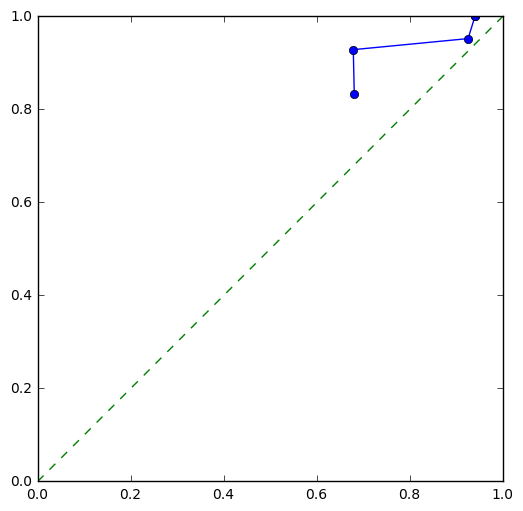

In [173]:
print('True Positive ERROR is : ', sumTPR)
print('False Positive ERROR is : ', sumFPR)
print(FPRvec)
print(TPRvec)
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as pl
# import numpy as np

TPRData = np.genfromtxt('TPR2.csv', delimiter=",")
FPRData = np.genfromtxt('FPR2.csv', delimiter=",")

# print(FPRData, TPRData)
pl.figure(figsize=(6,6))
pl.plot(FPRData, TPRData, 'o-')
pl.plot([0,1],[0,1],'--')

pl.show()

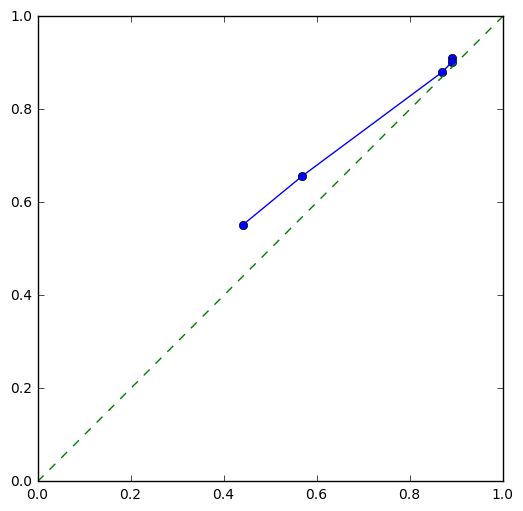

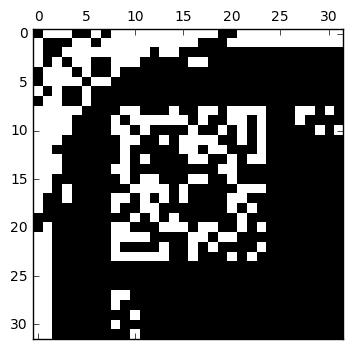

In [95]:
pl.spy(Ematrix)
pl.show()

('+++++++++++++++++++++++++++', 'Test For ', 'test2_sufficient_statistics.csv', '+++++++++++++++++++++++++++')
(4990, 8) (4990, 8) (4990, 16) (4990, 24)
(57, 57)
[[ 1.366  0.154  0.207 ...,  0.202  0.206  0.203]
 [ 0.154  1.4    0.227 ...,  0.22   0.224  0.22 ]
 [ 0.207  0.227  1.578 ...,  0.315  0.32   0.316]
 ..., 
 [ 0.202  0.22   0.315 ...,  0.35   0.344  0.342]
 [ 0.206  0.224  0.32  ...,  0.344  0.362  0.347]
 [ 0.203  0.22   0.316 ...,  0.342  0.347  0.355]]


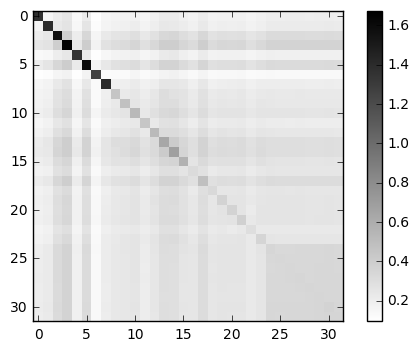

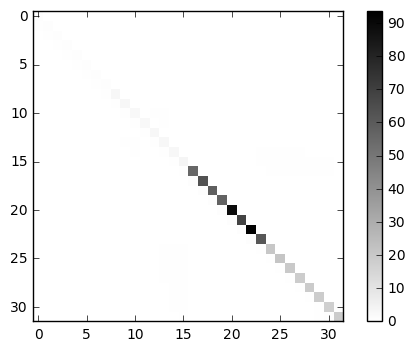

In [171]:
file_name = 'test2_sufficient_statistics.csv'
file_name2 = 'test2_edges.csv'
print('+++++++++++++++++++++++++++', 'Test For ', file_name, '+++++++++++++++++++++++++++')

#     print('TEST for :')
#     print(file_name)
#     print(file_name2)
#     print()

#########################################################################################################
# number of Bernoulli sample, Bernoulli T(x) dimension
# number of Gamma sample, Gamma T(x) dimension
# number of Gaussian sample, Gaussian T(x) dimension
# number of Dirichlet sample, Dirichlet T(x) dimension
# respectively

# n_r[0], m_t[0], n_t[1], m_r[1], n_r[2], m_t[2], n_r[3], m_t[3]
data = np.genfromtxt(file_name, delimiter=",")
m1 = 8
m2 = 8
m3 = 8
m4 = 8

dim1 = 1
dim2 = 1
dim3 = 2
dim4 = 3

m = np.array([1, m1, m2, m3, m4])
dim = np.array([1, dim1, dim2, dim3, dim4])
#########################################################################################################

#     balance = np.sqrt(dim)
# balance = [1, 1, 2, 3, 5]
balance = ([1, 1, 1, 3, 4 ])

M = Mmatrix(data, m, dim, balance)
print M.shape
D = Dmatrix(m, dim) 
A = M+D
A = np.matrix(A) #+ np.identity(57)
A = (A + np.transpose(A))/2


def EdgeNormMatrix(theta, m_vec, dim_vec, tolerance):
    #m_vec = np.array([1, 8, 8, 8, 8]) # 1 for dummy variable
    #dim_vec = np.array([1, 1, 1, 2, 3]) # 1 for dummy variable, 
    
    m = m_vec
    dim = dim_vec
    
    dist_num = np.sum(m)-1
    E = np.zeros([dist_num+1,dist_num+1])
#     dist_num = 32;
#     B = [ [] for i in range(dist_num+1)] # [  [], [], [], ... [] ]
    
    
    temp_vec = []
    for i in range(dist_num+1): # iterate from 0 to 32
        for j in range(dist_num+1):
#             B[i].append(Block_Extract(theta, i, j, m, dim)) # Helper function called "Block_Extract"
            temp = la.norm(Block_Extract(theta, i, j, m, dim), 'fro')
#             temp_vec.append(temp)
            if temp >= tolerance: ###### tolerance!!! #### TEST FOR CHANGE ####
                E[i,j] = temp
            else:
                E[i,j] = 0

    return E[1:,1:]

EE_theta = EdgeNormMatrix(optimal_theta, m, dim, tol)
EE = EdgeNormMatrix((A), m, dim, tol)

# EE = EdgeNormMatrix(la.inv(A), m, dim, tol)
print EE


pl.imshow(EE,interpolation='none',cmap='binary')
pl.colorbar()

pl.show()
pl.imshow(EE_theta,interpolation='none',cmap='binary')
pl.colorbar()
pl.show()

In [162]:
print ber_data

NameError: name 'ber_data' is not defined